In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ssl
import warnings
import certifi
import optuna

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, roc_curve 

In [2]:
warnings.filterwarnings('ignore')
ssl._create_default_https_context = lambda *args, **kwargs: ssl.create_default_context(cafile=certifi.where())

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/og_mel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/og_mel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/og_mel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/og_mel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv('data/ks-projects-201801.csv', parse_dates = ['deadline', 'launched'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                378661 non-null  int64         
 1   name              378657 non-null  object        
 2   category          378661 non-null  object        
 3   main_category     378661 non-null  object        
 4   currency          378661 non-null  object        
 5   deadline          378661 non-null  datetime64[ns]
 6   goal              378661 non-null  float64       
 7   launched          378661 non-null  datetime64[ns]
 8   pledged           378661 non-null  float64       
 9   state             378661 non-null  object        
 10  backers           378661 non-null  int64         
 11  country           378661 non-null  object        
 12  usd pledged       374864 non-null  float64       
 13  usd_pledged_real  378661 non-null  float64       
 14  usd_

In [6]:
df.describe()

,ID,deadline,goal,launched,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378661,3.786610e+05,378661,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,2014-11-01 16:04:27.950488832,4.908079e+04,2014-09-28 18:06:17.416520448,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
min,5.971000e+03,2009-05-03 00:00:00,1.000000e-02,1970-01-01 01:00:00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2013-06-08 00:00:00,2.000000e+03,2013-05-07 22:14:27,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,2015-01-14 00:00:00,5.200000e+03,2014-12-10 03:23:41,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,2016-04-28 00:00:00,1.600000e+04,2016-03-24 10:21:09,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,2018-03-03 00:00:00,1.000000e+08,2018-01-02 15:02:31,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08
std,6.190862e+08,NaN,1.183391e+06,NaN,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06


In [7]:
df.size, df.shape

(5679915, (378661, 15))

In [8]:
status_c = df['state'].value_counts(normalize = True)
status_c

state
failed        0.522153
successful    0.353762
canceled      0.102411
undefined     0.009407
live          0.007392
suspended     0.004875
Name: proportion, dtype: float64

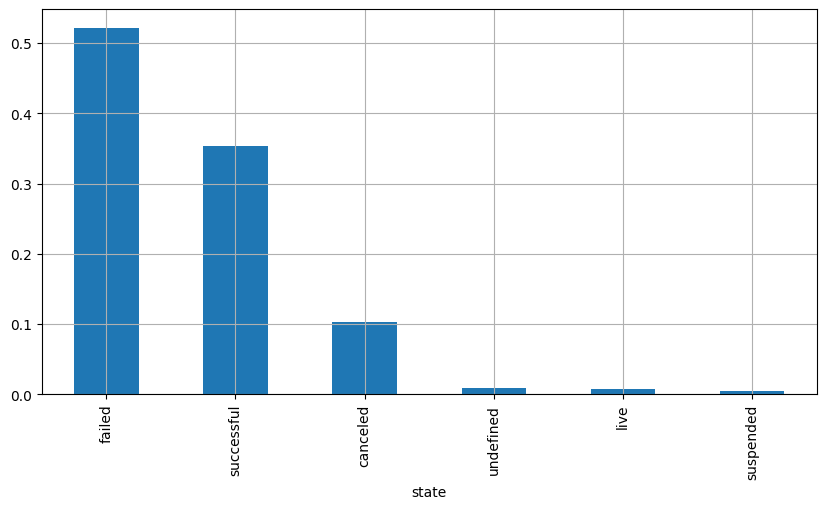

In [9]:
plt.figure(figsize = (10, 5))
status_c.plot(kind = 'bar')
plt.grid()
plt.show()

In [10]:
df = df[df['state'].isin(['failed', 'successful'])]
df['success'] = (df['state'] == 'successful').astype(int)
suc_rate = df['success'].mean()
suc_rate

np.float64(0.4038772895153388)

In [11]:
cols_to_drop = ['ID', 'pledged', 'usd pledged', 'state', 'backers'] # тут почти все удаляется по причине того, что информация известна после "опубликовки"
df = df.drop(columns = cols_to_drop)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331675 entries, 0 to 378660
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   name              331672 non-null  object        
 1   category          331675 non-null  object        
 2   main_category     331675 non-null  object        
 3   currency          331675 non-null  object        
 4   deadline          331675 non-null  datetime64[ns]
 5   goal              331675 non-null  float64       
 6   launched          331675 non-null  datetime64[ns]
 7   country           331675 non-null  object        
 8   usd_pledged_real  331675 non-null  float64       
 9   usd_goal_real     331675 non-null  float64       
 10  success           331675 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 30.4+ MB


In [13]:
for i in df.columns:
    print(i, df[i].isna().sum())

name 3
category 0
main_category 0
currency 0
deadline 0
goal 0
launched 0
country 0
usd_pledged_real 0
usd_goal_real 0
success 0


In [14]:
df['name'] = df['name'].fillna("Unknown")

In [15]:
df['launch_year'] = df['launched'].dt.year
df['launch_month'] = df['launched'].dt.month
df['launch_day'] = df['launched'].dt.day
df['launch_dayofweek'] = df['launched'].dt.dayofweek
df['launch_hour'] = df['launched'].dt.hour

In [16]:
df['duration_days'] = (df['deadline'] - df['launched']).dt.days
df['log_real'] = np.log1p(df['usd_goal_real'])

In [17]:
df = df.drop(columns = ['launched', 'deadline'])

In [18]:
df.head()

,name,category,main_category,currency,goal,country,usd_pledged_real,usd_goal_real,success,launch_year,launch_month,launch_day,launch_dayofweek,launch_hour,duration_days,log_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,GB,0.0,1533.95,0,2015,8,11,1,12,58,7.336253
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,US,2421.0,30000.00,0,2017,9,2,5,4,59,10.308986
2,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,US,220.0,45000.00,0,2013,1,12,5,0,44,10.714440
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,US,1.0,5000.00,0,2012,3,17,5,3,29,8.517393
5,Monarch Espresso Bar,Restaurants,Food,USD,50000.0,US,52375.0,50000.00,1,2016,2,26,4,13,34,10.819798


In [19]:
df['category'].unique(), df['main_category'].unique(), df['currency'].unique(), df['country'].unique()

(array(['Poetry', 'Narrative Film', 'Music', 'Restaurants', 'Food',
        'Drinks', 'Nonfiction', 'Indie Rock', 'Crafts', 'Games',
        'Tabletop Games', 'Design', 'Comic Books', 'Art Books', 'Fashion',
        'Childrenswear', 'Theater', 'Comics', 'DIY', 'Webseries',
        'Animation', 'Food Trucks', 'Product Design', 'Public Art',
        'Documentary', 'Illustration', 'Photography', 'Pop', 'People',
        'Art', 'Family', 'Fiction', 'Film & Video', 'Accessories', 'Rock',
        'Hardware', 'Software', 'Weaving', 'Web', 'Jazz', 'Ready-to-wear',
        'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
        'Gadgets', 'Electronic Music', 'Radio & Podcasts', 'Cookbooks',
        'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
        'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
        'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
        'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
 

In [20]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
        
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [21]:
df['name_prep'] = df['name'].apply(preprocess_text)
df['name_len'] = df['name_prep'].apply(lambda x: len(x.split()))
df['name_sent'] = df['name_prep'].apply(
    lambda x: TextBlob(x).sentiment.polarity if x.strip() != '' else 0
)

In [22]:
df.head()

,name,category,main_category,currency,goal,country,usd_pledged_real,usd_goal_real,success,launch_year,launch_month,launch_day,launch_dayofweek,launch_hour,duration_days,log_real,name_prep,name_len,name_sent
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,GB,0.0,1533.95,0,2015,8,11,1,12,58,7.336253,song adelaide abullah,3,0.0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,US,2421.0,30000.00,0,2017,9,2,5,4,59,10.308986,greeting earth zgac art capsule et,6,0.0
2,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,US,220.0,45000.00,0,2013,1,12,5,0,44,10.714440,hank,1,0.0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,US,1.0,5000.00,0,2012,3,17,5,3,29,8.517393,toshicapital rekordz need help complete album,6,0.1
5,Monarch Espresso Bar,Restaurants,Food,USD,50000.0,US,52375.0,50000.00,1,2016,2,26,4,13,34,10.819798,monarch espresso bar,3,0.0


In [23]:
df['creator_id'] = df['main_category'] + '_' + df['country']
df = df.sort_values('launch_year')
creator_history = df.groupby('creator_id').agg(
    {
        'success': ['count', 'mean'],
        'usd_goal_real': 'mean'
    }
).reset_index()

creator_history.columns = ['creator_id', 'creator_projects_count', 
                           'creator_success_rate', 'creator_avg_goal']

In [24]:
df = pd.merge(df, creator_history, on = 'creator_id', how = 'left')

In [25]:
for i in df.columns:
    print(i, df[i].isna().sum())

name 0
category 0
main_category 0
currency 0
goal 0
country 0
usd_pledged_real 0
usd_goal_real 0
success 0
launch_year 0
launch_month 0
launch_day 0
launch_dayofweek 0
launch_hour 0
duration_days 0
log_real 0
name_prep 0
name_len 0
name_sent 0
creator_id 0
creator_projects_count 0
creator_success_rate 0
creator_avg_goal 0


In [26]:
df = df.drop(columns = ['name', 'creator_id', 'usd_pledged_real', 'goal'])

In [27]:
df.head()

,category,main_category,currency,country,usd_goal_real,success,launch_year,launch_month,launch_day,launch_dayofweek,launch_hour,duration_days,log_real,name_prep,name_len,name_sent,creator_projects_count,creator_success_rate,creator_avg_goal
0,Shorts,Film & Video,USD,US,6500.0,1,2009,12,14,0,20,89,8.779711,cherry bomb time beat hollywood game,6,-0.400000,46933,0.421494,72271.050943
1,Pop,Music,USD,US,20000.0,0,2009,9,14,0,19,77,9.903538,impossible girl solo record,4,-0.666667,40225,0.539913,14292.655761
2,Sculpture,Art,USD,US,2500.0,1,2009,11,5,3,20,46,7.824446,stick travel world tour,4,0.000000,20449,0.464375,32272.324104
3,Video Games,Games,USD,US,1500.0,1,2009,5,20,2,22,89,7.313887,high strangeness bit action adventure video game,7,-0.046667,20229,0.462504,43053.645051
4,Shorts,Film & Video,USD,US,5000.0,1,2009,7,21,1,0,88,8.517393,first time,2,0.250000,46933,0.421494,72271.050943


<Axes: >

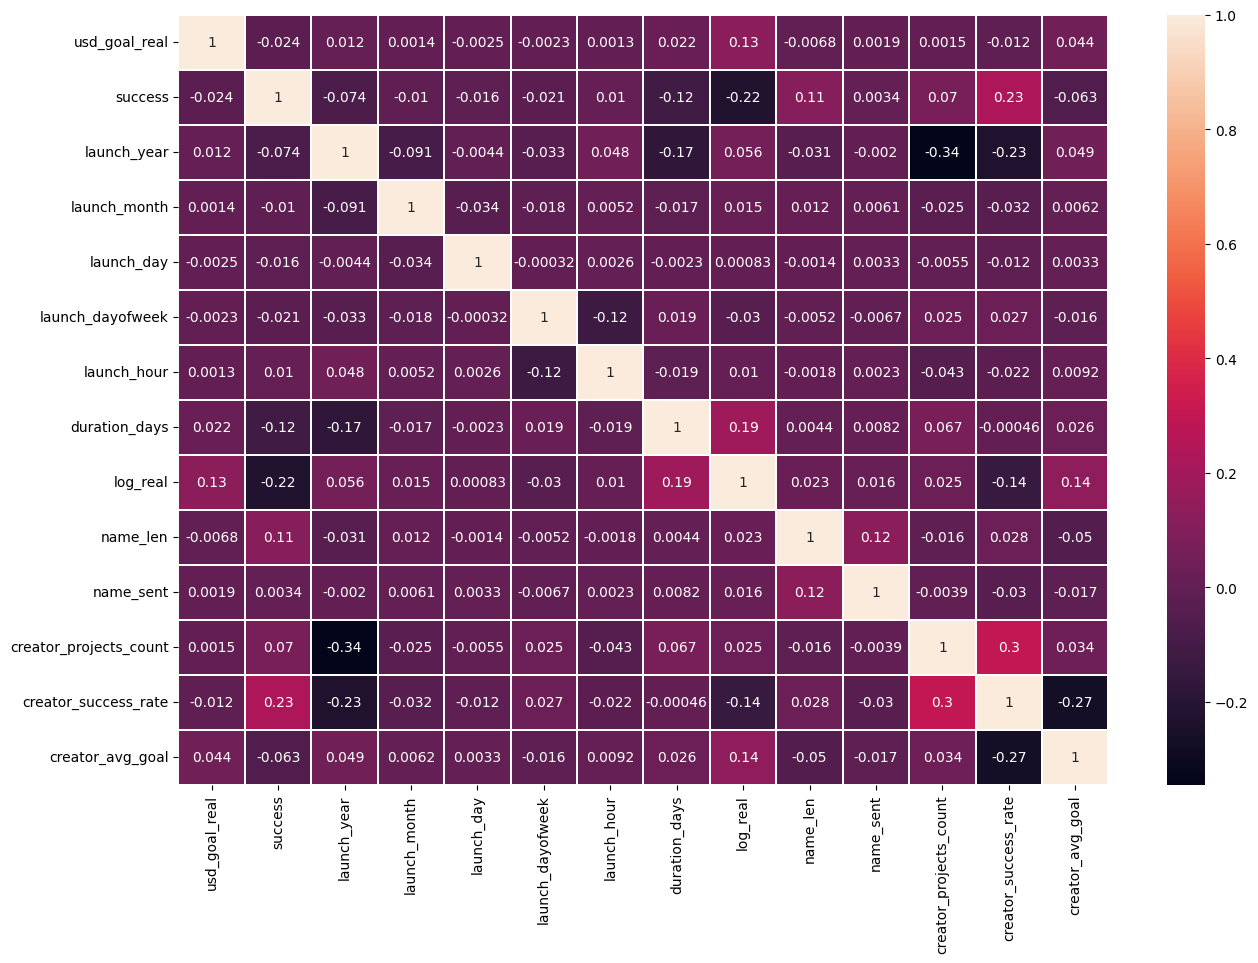

In [28]:
plt.figure(figsize = (15, 10))
corr_matrix = df.corr(numeric_only = True, method = 'pearson')
sns.heatmap(corr_matrix, linewidth = 0.01, annot = True)

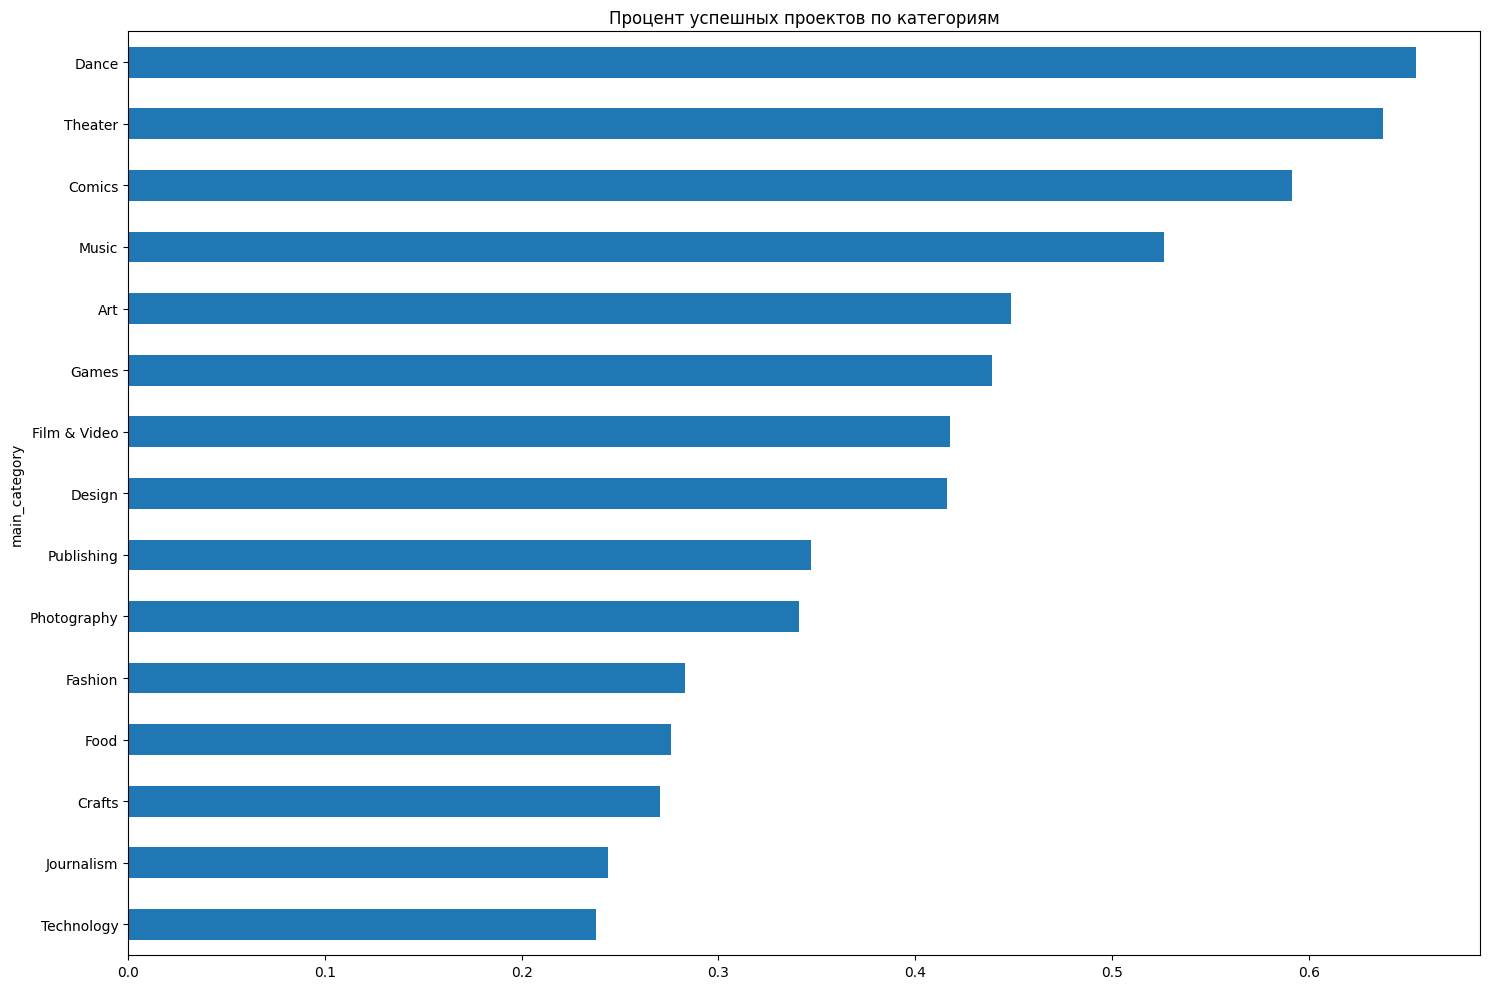

In [29]:
plt.figure(figsize = (15, 10))
cat_suc = df.groupby('main_category')['success'].mean().sort_values()
cat_suc.plot(kind = 'barh')
plt.title('Процент успешных проектов по категориям')
plt.tight_layout()
plt.show()

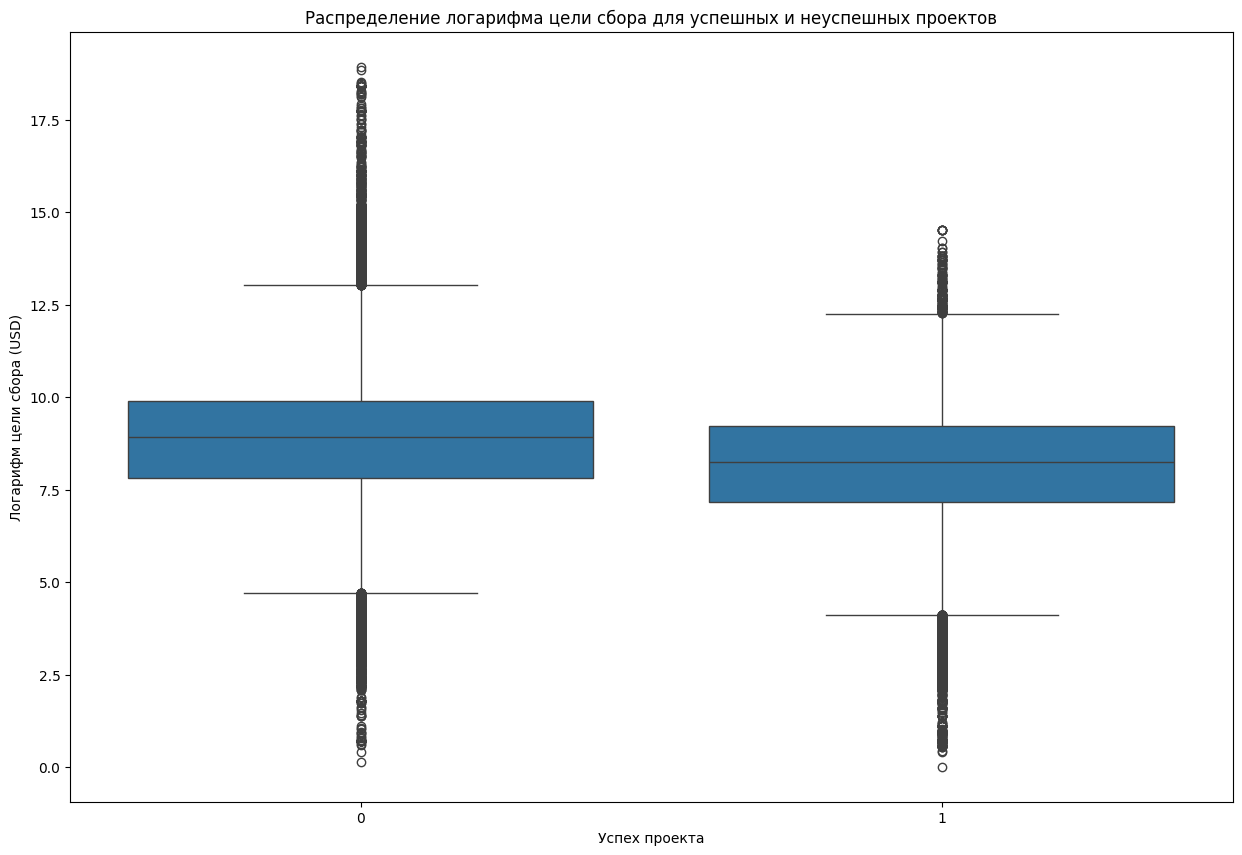

In [30]:
plt.figure(figsize = (15, 10))
sns.boxplot(x = 'success', y = 'log_real', data = df)
plt.title('Распределение логарифма цели сбора для успешных и неуспешных проектов')
plt.xlabel('Успех проекта')
plt.ylabel('Логарифм цели сбора (USD)')
plt.show()

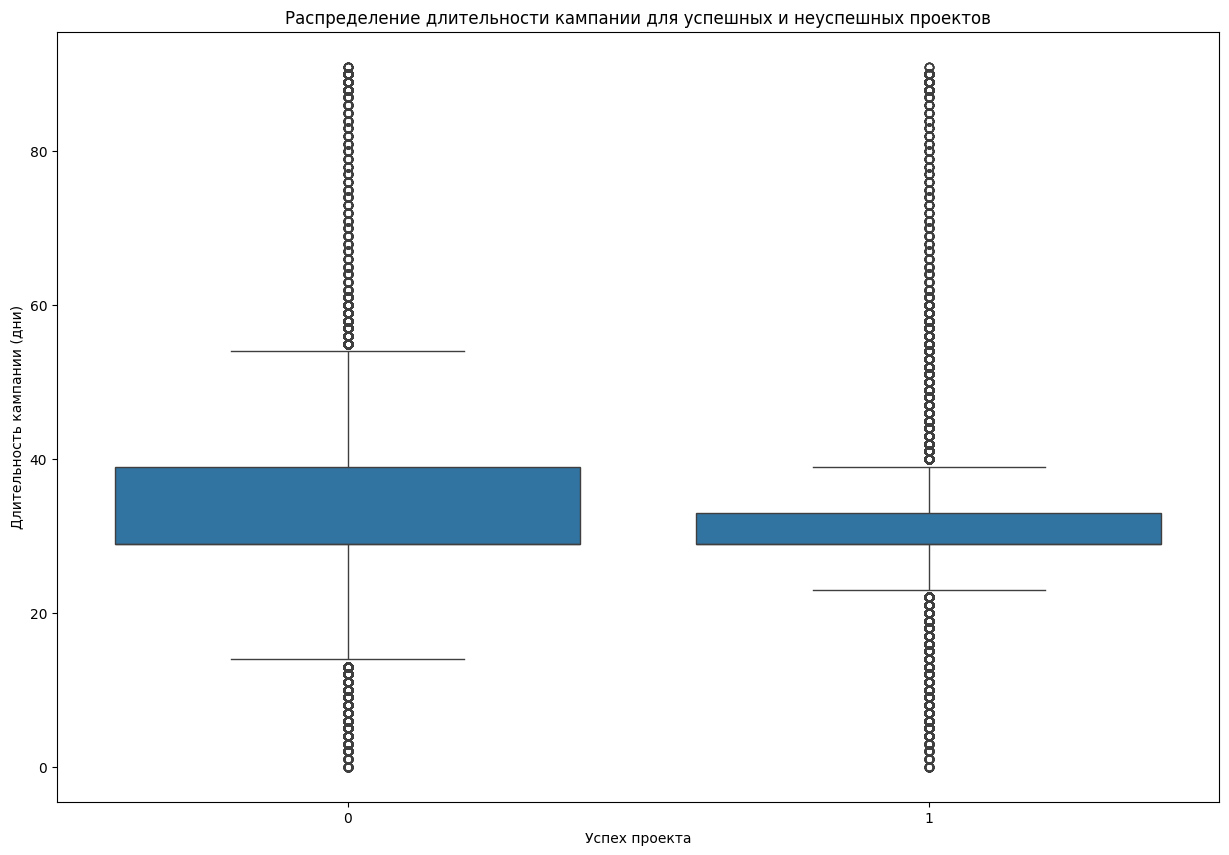

In [31]:
plt.figure(figsize = (15, 10))
sns.boxplot(x = 'success', y = 'duration_days', data = df)
plt.title('Распределение длительности кампании для успешных и неуспешных проектов')
plt.xlabel('Успех проекта')
plt.ylabel('Длительность кампании (дни)')
plt.show()

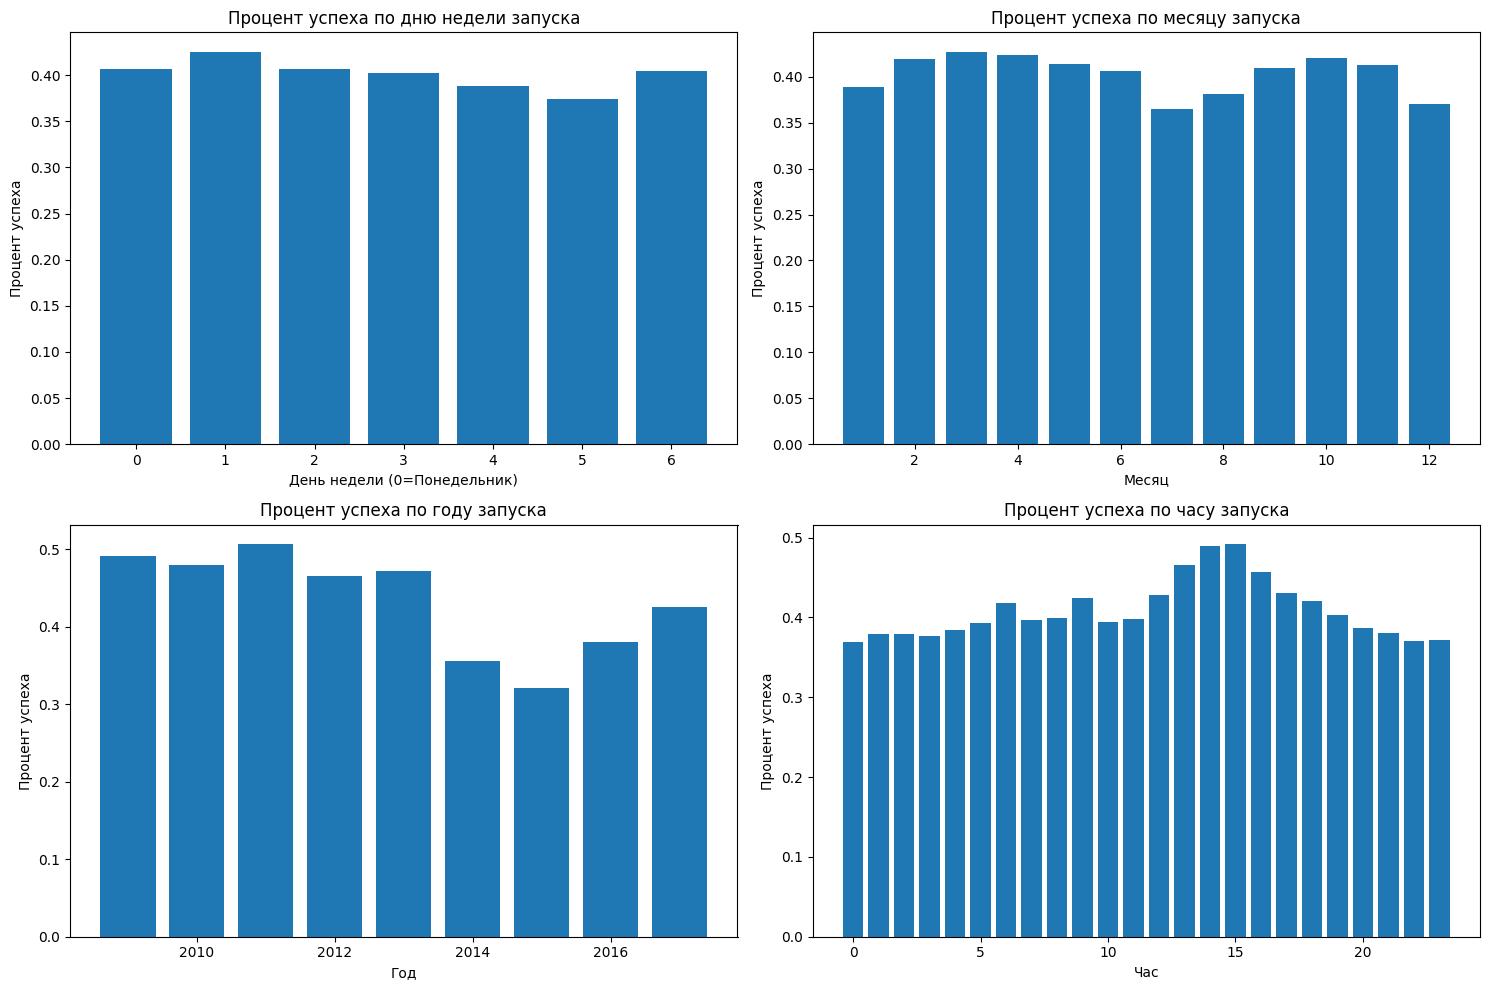

In [32]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

# День недели
day_of_week_success = df.groupby('launch_dayofweek')['success'].mean()
axes[0, 0].bar(day_of_week_success.index, day_of_week_success.values)
axes[0, 0].set_title('Процент успеха по дню недели запуска')
axes[0, 0].set_xlabel('День недели (0=Понедельник)')
axes[0, 0].set_ylabel('Процент успеха')

# Месяц
month_success = df.groupby('launch_month')['success'].mean()
axes[0, 1].bar(month_success.index, month_success.values)
axes[0, 1].set_title('Процент успеха по месяцу запуска')
axes[0, 1].set_xlabel('Месяц')
axes[0, 1].set_ylabel('Процент успеха')

# Год
year_success = df.groupby('launch_year')['success'].mean()
axes[1, 0].bar(year_success.index, year_success.values)
axes[1, 0].set_title('Процент успеха по году запуска')
axes[1, 0].set_xlabel('Год')
axes[1, 0].set_ylabel('Процент успеха')

# Час
hour_success = df.groupby('launch_hour')['success'].mean()
axes[1, 1].bar(hour_success.index, hour_success.values)
axes[1, 1].set_title('Процент успеха по часу запуска')
axes[1, 1].set_xlabel('Час')
axes[1, 1].set_ylabel('Процент успеха')

plt.tight_layout()
plt.show()

In [33]:
X = df.drop(columns = ['success'])
y = df['success']

In [34]:
numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include = ['object']).columns.tolist()
text_columns = ['name_prep']

In [35]:
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])
text_transformer = Pipeline(steps = [
    ('tfidf', TfidfVectorizer(max_features = 3000, stop_words='english'))
])

In [36]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_columns[0])
    ])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y
)

In [38]:
X_train.shape, X_test.shape

((265340, 18), (66335, 18))

In [39]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        class_weight = 'balanced',
        random_state = 42,
        n_jobs = -1
    )
    
    pipeline_rf = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline_rf.fit(X_train, y_train)
    y_pred_proba = pipeline_rf.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

In [40]:
study_rf = optuna.create_study(direction = 'maximize')
study_rf.optimize(objective_rf, n_trials = 30, show_progress_bar = True)
best_params_rf = study_rf.best_params
print("Лучшие гиперпараметры RandomForest:", best_params_rf)

[I 2025-08-29 18:15:47,191] A new study created in memory with name: no-name-786df16a-91c8-42ac-898b-3cf889db35ad
Best trial: 0. Best value: 0.697811:   3%|██▉                                                                                      | 1/30 [00:02<01:12,  2.51s/it]

[I 2025-08-29 18:15:49,729] Trial 0 finished with value: 0.697810957818991 and parameters: {'n_estimators': 146, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.697810957818991.


Best trial: 1. Best value: 0.698584:   7%|█████▉                                                                                   | 2/30 [00:05<01:17,  2.76s/it]

[I 2025-08-29 18:15:52,673] Trial 1 finished with value: 0.6985840100039936 and parameters: {'n_estimators': 219, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.6985840100039936.


Best trial: 2. Best value: 0.704573:  10%|████████▉                                                                                | 3/30 [00:08<01:18,  2.91s/it]

[I 2025-08-29 18:15:55,748] Trial 2 finished with value: 0.7045734558431046 and parameters: {'n_estimators': 223, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.7045734558431046.


Best trial: 2. Best value: 0.704573:  13%|███████████▊                                                                             | 4/30 [00:10<01:10,  2.72s/it]

[I 2025-08-29 18:15:58,193] Trial 3 finished with value: 0.6941980686314976 and parameters: {'n_estimators': 152, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7045734558431046.


Best trial: 4. Best value: 0.709076:  17%|██████████████▊                                                                          | 5/30 [00:13<01:04,  2.60s/it]

[I 2025-08-29 18:16:00,568] Trial 4 finished with value: 0.7090758605778225 and parameters: {'n_estimators': 117, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  20%|█████████████████▊                                                                       | 6/30 [00:15<01:01,  2.57s/it]

[I 2025-08-29 18:16:03,096] Trial 5 finished with value: 0.696920965597336 and parameters: {'n_estimators': 167, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  23%|████████████████████▊                                                                    | 7/30 [00:20<01:10,  3.08s/it]

[I 2025-08-29 18:16:07,226] Trial 6 finished with value: 0.7074404444099334 and parameters: {'n_estimators': 399, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  27%|███████████████████████▋                                                                 | 8/30 [00:23<01:08,  3.10s/it]

[I 2025-08-29 18:16:10,377] Trial 7 finished with value: 0.7021955932923296 and parameters: {'n_estimators': 308, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  30%|██████████████████████████▋                                                              | 9/30 [00:26<01:05,  3.11s/it]

[I 2025-08-29 18:16:13,497] Trial 8 finished with value: 0.6971592844063019 and parameters: {'n_estimators': 261, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  33%|█████████████████████████████▎                                                          | 10/30 [00:28<00:57,  2.87s/it]

[I 2025-08-29 18:16:15,817] Trial 9 finished with value: 0.7064344555894345 and parameters: {'n_estimators': 108, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  37%|████████████████████████████████▎                                                       | 11/30 [00:32<01:00,  3.21s/it]

[I 2025-08-29 18:16:19,795] Trial 10 finished with value: 0.701830080282999 and parameters: {'n_estimators': 490, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  40%|███████████████████████████████████▏                                                    | 12/30 [00:36<01:02,  3.46s/it]

[I 2025-08-29 18:16:23,847] Trial 11 finished with value: 0.703159100981981 and parameters: {'n_estimators': 384, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  43%|██████████████████████████████████████▏                                                 | 13/30 [00:40<01:02,  3.70s/it]

[I 2025-08-29 18:16:28,078] Trial 12 finished with value: 0.704564330595469 and parameters: {'n_estimators': 398, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  47%|█████████████████████████████████████████                                               | 14/30 [00:44<00:59,  3.72s/it]

[I 2025-08-29 18:16:31,850] Trial 13 finished with value: 0.7022078391056423 and parameters: {'n_estimators': 355, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  50%|████████████████████████████████████████████                                            | 15/30 [00:48<00:57,  3.86s/it]

[I 2025-08-29 18:16:36,039] Trial 14 finished with value: 0.7065696725508315 and parameters: {'n_estimators': 457, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  53%|██████████████████████████████████████████████▉                                         | 16/30 [00:53<00:56,  4.04s/it]

[I 2025-08-29 18:16:40,482] Trial 15 finished with value: 0.7083571162410449 and parameters: {'n_estimators': 426, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  57%|█████████████████████████████████████████████████▊                                      | 17/30 [00:56<00:50,  3.85s/it]

[I 2025-08-29 18:16:43,912] Trial 16 finished with value: 0.7041501562061164 and parameters: {'n_estimators': 330, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  60%|████████████████████████████████████████████████████▊                                   | 18/30 [01:00<00:44,  3.70s/it]

[I 2025-08-29 18:16:47,264] Trial 17 finished with value: 0.6962171770388015 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  63%|███████████████████████████████████████████████████████▋                                | 19/30 [01:04<00:43,  3.95s/it]

[I 2025-08-29 18:16:51,777] Trial 18 finished with value: 0.7049683796647916 and parameters: {'n_estimators': 451, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  67%|██████████████████████████████████████████████████████████▋                             | 20/30 [01:06<00:34,  3.44s/it]

[I 2025-08-29 18:16:54,023] Trial 19 finished with value: 0.7000748786624765 and parameters: {'n_estimators': 104, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  70%|█████████████████████████████████████████████████████████████▌                          | 21/30 [01:09<00:29,  3.28s/it]

[I 2025-08-29 18:16:56,933] Trial 20 finished with value: 0.7007649446608737 and parameters: {'n_estimators': 201, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  73%|████████████████████████████████████████████████████████████████▌                       | 22/30 [01:14<00:28,  3.61s/it]

[I 2025-08-29 18:17:01,302] Trial 21 finished with value: 0.7067202606107672 and parameters: {'n_estimators': 423, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  77%|███████████████████████████████████████████████████████████████████▍                    | 23/30 [01:18<00:25,  3.71s/it]

[I 2025-08-29 18:17:05,267] Trial 22 finished with value: 0.7042598909075913 and parameters: {'n_estimators': 358, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  80%|██████████████████████████████████████████████████████████████████████▍                 | 24/30 [01:23<00:24,  4.09s/it]

[I 2025-08-29 18:17:10,250] Trial 23 finished with value: 0.7057459154211695 and parameters: {'n_estimators': 499, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  83%|█████████████████████████████████████████████████████████████████████████▎              | 25/30 [01:27<00:20,  4.13s/it]

[I 2025-08-29 18:17:14,452] Trial 24 finished with value: 0.7041701954103892 and parameters: {'n_estimators': 422, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  87%|████████████████████████████████████████████████████████████████████████████▎           | 26/30 [01:30<00:15,  3.91s/it]

[I 2025-08-29 18:17:17,873] Trial 25 finished with value: 0.7019546414470792 and parameters: {'n_estimators': 270, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 27/30 [01:35<00:12,  4.05s/it]

[I 2025-08-29 18:17:22,242] Trial 26 finished with value: 0.7034578904260161 and parameters: {'n_estimators': 452, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  93%|██████████████████████████████████████████████████████████████████████████████████▏     | 28/30 [01:39<00:08,  4.13s/it]

[I 2025-08-29 18:17:26,550] Trial 27 finished with value: 0.7023474362802953 and parameters: {'n_estimators': 377, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076:  97%|█████████████████████████████████████████████████████████████████████████████████████   | 29/30 [01:43<00:04,  4.05s/it]

[I 2025-08-29 18:17:30,423] Trial 28 finished with value: 0.707419965815666 and parameters: {'n_estimators': 330, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7090758605778225.


Best trial: 4. Best value: 0.709076: 100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:47<00:00,  3.57s/it]

[I 2025-08-29 18:17:34,468] Trial 29 finished with value: 0.7045818259629297 and parameters: {'n_estimators': 401, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7090758605778225.
Лучшие гиперпараметры RandomForest: {'n_estimators': 117, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}


In [41]:
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log = True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    model = GradientBoostingClassifier(
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_depth = max_depth,
        subsample = subsample,
        random_state = 42
    )
    
    pipeline_gb = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline_gb.fit(X_train, y_train)
    y_pred_proba = pipeline_gb.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

In [42]:
study_gb = optuna.create_study(direction = 'maximize')
study_gb.optimize(objective_gb, n_trials = 30, show_progress_bar = True)
best_params_gb = study_gb.best_params
print("Лучшие гиперпараметры GradientBoosting:", best_params_gb)

[I 2025-08-29 18:17:41,184] A new study created in memory with name: no-name-9a032ef3-9b77-4c12-8d9c-e6f846ded293
Best trial: 0. Best value: 0.764938:   3%|██▊                                                                                   | 1/30 [06:36<3:11:51, 396.95s/it]

[I 2025-08-29 18:24:18,140] Trial 0 finished with value: 0.7649378793540301 and parameters: {'n_estimators': 252, 'learning_rate': 0.15524020703711497, 'max_depth': 10, 'subsample': 0.6713074742179003}. Best is trial 0 with value: 0.7649378793540301.


Best trial: 0. Best value: 0.764938:   7%|█████▋                                                                                | 2/30 [08:10<1:42:04, 218.72s/it]

[I 2025-08-29 18:25:52,091] Trial 1 finished with value: 0.7444140736968347 and parameters: {'n_estimators': 244, 'learning_rate': 0.060119794247136794, 'max_depth': 3, 'subsample': 0.6595327555544169}. Best is trial 0 with value: 0.7649378793540301.


Best trial: 0. Best value: 0.764938:  10%|████████▌                                                                             | 3/30 [09:01<1:03:52, 141.95s/it]

[I 2025-08-29 18:26:42,695] Trial 2 finished with value: 0.7492480323993326 and parameters: {'n_estimators': 115, 'learning_rate': 0.19585489526808034, 'max_depth': 3, 'subsample': 0.7334313862953751}. Best is trial 0 with value: 0.7649378793540301.


Best trial: 0. Best value: 0.764938:  13%|███████████▍                                                                          | 4/30 [12:53<1:16:51, 177.35s/it]

[I 2025-08-29 18:30:34,312] Trial 3 finished with value: 0.7506300238983604 and parameters: {'n_estimators': 158, 'learning_rate': 0.029008919703277628, 'max_depth': 8, 'subsample': 0.7117958969788196}. Best is trial 0 with value: 0.7649378793540301.


Best trial: 0. Best value: 0.764938:  17%|██████████████▎                                                                       | 5/30 [21:45<2:07:16, 305.47s/it]

[I 2025-08-29 18:39:26,949] Trial 4 finished with value: 0.7648460605318155 and parameters: {'n_estimators': 355, 'learning_rate': 0.15761818167324046, 'max_depth': 10, 'subsample': 0.6774080542684704}. Best is trial 0 with value: 0.7649378793540301.


Best trial: 0. Best value: 0.764938:  20%|█████████████████▏                                                                    | 6/30 [23:47<1:37:14, 243.11s/it]

[I 2025-08-29 18:41:29,008] Trial 5 finished with value: 0.7361370318695576 and parameters: {'n_estimators': 146, 'learning_rate': 0.015867658086918632, 'max_depth': 6, 'subsample': 0.6468250536002099}. Best is trial 0 with value: 0.7649378793540301.


Best trial: 6. Best value: 0.765535:  23%|████████████████████                                                                  | 7/30 [31:57<2:04:02, 323.59s/it]

[I 2025-08-29 18:49:38,280] Trial 6 finished with value: 0.7655350646317292 and parameters: {'n_estimators': 307, 'learning_rate': 0.11026838349102257, 'max_depth': 9, 'subsample': 0.7952108748311449}. Best is trial 6 with value: 0.7655350646317292.


Best trial: 6. Best value: 0.765535:  27%|██████████████████████▉                                                               | 8/30 [38:09<2:04:18, 339.03s/it]

[I 2025-08-29 18:55:50,391] Trial 7 finished with value: 0.7527945972953602 and parameters: {'n_estimators': 404, 'learning_rate': 0.03570315940450145, 'max_depth': 5, 'subsample': 0.949375041412859}. Best is trial 6 with value: 0.7655350646317292.


Best trial: 6. Best value: 0.765535:  30%|█████████████████████████▊                                                            | 9/30 [48:31<2:29:38, 427.54s/it]

[I 2025-08-29 19:06:12,547] Trial 8 finished with value: 0.7517267625632671 and parameters: {'n_estimators': 320, 'learning_rate': 0.011740827103877917, 'max_depth': 9, 'subsample': 0.7821175521554392}. Best is trial 6 with value: 0.7655350646317292.


Best trial: 6. Best value: 0.765535:  33%|████████████████████████████▎                                                        | 10/30 [55:28<2:21:23, 424.18s/it]

[I 2025-08-29 19:13:09,189] Trial 9 finished with value: 0.7627623400853564 and parameters: {'n_estimators': 296, 'learning_rate': 0.06614685142854884, 'max_depth': 8, 'subsample': 0.7662763577996374}. Best is trial 6 with value: 0.7655350646317292.


Best trial: 10. Best value: 0.766458:  37%|██████████████████████████████                                                    | 11/30 [1:05:25<2:31:07, 477.25s/it]

[I 2025-08-29 19:23:06,766] Trial 10 finished with value: 0.7664581706237414 and parameters: {'n_estimators': 471, 'learning_rate': 0.0983687909820675, 'max_depth': 7, 'subsample': 0.8902160061586355}. Best is trial 10 with value: 0.7664581706237414.


Best trial: 11. Best value: 0.766557:  40%|████████████████████████████████▊                                                 | 12/30 [1:15:41<2:35:51, 519.51s/it]

[I 2025-08-29 19:33:22,931] Trial 11 finished with value: 0.7665566879015908 and parameters: {'n_estimators': 492, 'learning_rate': 0.09683009604322745, 'max_depth': 7, 'subsample': 0.8842308228316734}. Best is trial 11 with value: 0.7665566879015908.


Best trial: 11. Best value: 0.766557:  43%|███████████████████████████████████▌                                              | 13/30 [1:24:35<2:28:25, 523.83s/it]

[I 2025-08-29 19:42:16,693] Trial 12 finished with value: 0.7645333941983969 and parameters: {'n_estimators': 487, 'learning_rate': 0.08297522408630065, 'max_depth': 6, 'subsample': 0.9027081845285838}. Best is trial 11 with value: 0.7665566879015908.


Best trial: 13. Best value: 0.766742:  47%|██████████████████████████████████████▎                                           | 14/30 [1:34:50<2:27:02, 551.38s/it]

[I 2025-08-29 19:52:31,755] Trial 13 finished with value: 0.766742485683513 and parameters: {'n_estimators': 495, 'learning_rate': 0.10165037268739989, 'max_depth': 7, 'subsample': 0.872966535286575}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  50%|█████████████████████████████████████████                                         | 15/30 [1:43:54<2:17:16, 549.07s/it]

[I 2025-08-29 20:01:35,462] Trial 14 finished with value: 0.762102545273065 and parameters: {'n_estimators': 424, 'learning_rate': 0.051937916387097306, 'max_depth': 7, 'subsample': 0.8602490278203485}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  53%|███████████████████████████████████████████▋                                      | 16/30 [1:50:46<1:58:29, 507.84s/it]

[I 2025-08-29 20:08:27,566] Trial 15 finished with value: 0.7633713402815614 and parameters: {'n_estimators': 432, 'learning_rate': 0.11996403417657744, 'max_depth': 5, 'subsample': 0.9902432622352528}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  57%|██████████████████████████████████████████████▍                                   | 17/30 [1:57:22<1:42:45, 474.30s/it]

[I 2025-08-29 20:15:03,870] Trial 16 finished with value: 0.7529756627856847 and parameters: {'n_estimators': 488, 'learning_rate': 0.028674273164395282, 'max_depth': 5, 'subsample': 0.8422798435065646}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  60%|█████████████████████████████████████████████████▏                                | 18/30 [2:07:15<1:41:58, 509.90s/it]

[I 2025-08-29 20:24:56,651] Trial 17 finished with value: 0.7649501355503503 and parameters: {'n_estimators': 377, 'learning_rate': 0.08166303190597266, 'max_depth': 8, 'subsample': 0.9332578667103715}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  63%|███████████████████████████████████████████████████▉                              | 19/30 [2:11:49<1:20:31, 439.21s/it]

[I 2025-08-29 20:29:31,175] Trial 18 finished with value: 0.7520188190989614 and parameters: {'n_estimators': 437, 'learning_rate': 0.042569496355557575, 'max_depth': 4, 'subsample': 0.8356719502363009}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  67%|██████████████████████████████████████████████████████▋                           | 20/30 [2:18:39<1:11:43, 430.33s/it]

[I 2025-08-29 20:36:20,809] Trial 19 finished with value: 0.7661850342872957 and parameters: {'n_estimators': 450, 'learning_rate': 0.13056537990008962, 'max_depth': 7, 'subsample': 0.6008160461280394}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  70%|█████████████████████████████████████████████████████████▍                        | 21/30 [2:28:27<1:11:39, 477.69s/it]

[I 2025-08-29 20:46:08,921] Trial 20 finished with value: 0.7630837224815286 and parameters: {'n_estimators': 498, 'learning_rate': 0.07797475152405492, 'max_depth': 6, 'subsample': 0.9972261239879806}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  73%|████████████████████████████████████████████████████████████▏                     | 22/30 [2:38:12<1:07:57, 509.72s/it]

[I 2025-08-29 20:55:53,350] Trial 21 finished with value: 0.7661643843734063 and parameters: {'n_estimators': 462, 'learning_rate': 0.09497424432571329, 'max_depth': 7, 'subsample': 0.8856508825594477}. Best is trial 13 with value: 0.766742485683513.


Best trial: 13. Best value: 0.766742:  77%|████████████████████████████████████████████████████████████████▍                   | 23/30 [2:46:23<58:48, 504.12s/it]

[I 2025-08-29 21:04:04,404] Trial 22 finished with value: 0.7647362668359804 and parameters: {'n_estimators': 392, 'learning_rate': 0.19547246334556512, 'max_depth': 7, 'subsample': 0.914762060770774}. Best is trial 13 with value: 0.766742485683513.


Best trial: 23. Best value: 0.767148:  80%|███████████████████████████████████████████████████████████████████▏                | 24/30 [2:57:29<55:17, 552.86s/it]

[I 2025-08-29 21:15:10,944] Trial 23 finished with value: 0.7671481342079294 and parameters: {'n_estimators': 465, 'learning_rate': 0.10000661955341474, 'max_depth': 8, 'subsample': 0.8695194175199982}. Best is trial 23 with value: 0.7671481342079294.


Best trial: 23. Best value: 0.767148:  83%|██████████████████████████████████████████████████████████████████████              | 25/30 [3:06:51<46:17, 555.49s/it]

[I 2025-08-29 21:24:32,571] Trial 24 finished with value: 0.7659909706875772 and parameters: {'n_estimators': 357, 'learning_rate': 0.14068223239058641, 'max_depth': 9, 'subsample': 0.8295066354160089}. Best is trial 23 with value: 0.7671481342079294.


Best trial: 23. Best value: 0.767148:  87%|████████████████████████████████████████████████████████████████████████▊           | 26/30 [3:18:14<39:35, 593.84s/it]

[I 2025-08-29 21:35:55,883] Trial 25 finished with value: 0.7654904686710573 and parameters: {'n_estimators': 460, 'learning_rate': 0.06327831990660757, 'max_depth': 8, 'subsample': 0.8665478240703508}. Best is trial 23 with value: 0.7671481342079294.


Best trial: 23. Best value: 0.767148:  90%|███████████████████████████████████████████████████████████████████████████▌        | 27/30 [3:32:09<33:18, 666.15s/it]

[I 2025-08-29 21:49:50,730] Trial 26 finished with value: 0.7632684352391781 and parameters: {'n_estimators': 499, 'learning_rate': 0.0477746398318757, 'max_depth': 8, 'subsample': 0.9633801948054581}. Best is trial 23 with value: 0.7671481342079294.


Best trial: 23. Best value: 0.767148:  93%|██████████████████████████████████████████████████████████████████████████████▍     | 28/30 [3:39:03<19:41, 590.59s/it]

[I 2025-08-29 21:56:45,035] Trial 27 finished with value: 0.7646756786841457 and parameters: {'n_estimators': 410, 'learning_rate': 0.10404215133533454, 'max_depth': 6, 'subsample': 0.8139717193631123}. Best is trial 23 with value: 0.7671481342079294.


Best trial: 23. Best value: 0.767148:  97%|█████████████████████████████████████████████████████████████████████████████████▏  | 29/30 [3:45:42<08:53, 533.05s/it]

[I 2025-08-29 22:03:23,828] Trial 28 finished with value: 0.7624983917665455 and parameters: {'n_estimators': 218, 'learning_rate': 0.07463615986027651, 'max_depth': 9, 'subsample': 0.8656363519585248}. Best is trial 23 with value: 0.7671481342079294.


Best trial: 23. Best value: 0.767148: 100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [3:59:50<00:00, 479.69s/it]

[I 2025-08-29 22:17:31,783] Trial 29 finished with value: 0.7654849803077391 and parameters: {'n_estimators': 456, 'learning_rate': 0.15956377043971734, 'max_depth': 10, 'subsample': 0.9271098102042642}. Best is trial 23 with value: 0.7671481342079294.
Лучшие гиперпараметры GradientBoosting: {'n_estimators': 465, 'learning_rate': 0.10000661955341474, 'max_depth': 8, 'subsample': 0.8695194175199982}


In [43]:
rf_model = RandomForestClassifier(
    **best_params_rf,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
gb_model = GradientBoostingClassifier(
    **best_params_gb,
    random_state=42
)

pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', gb_model)
])

pipeline_gb.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
rf_pred = pipeline_rf.predict(X_test)
rf_pred_proba = pipeline_rf.predict_proba(X_test)[:, 1]

gb_pred = pipeline_gb.predict(X_test)
gb_pred_proba = pipeline_gb.predict_proba(X_test)[:, 1]

In [52]:
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)

In [53]:
comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [rf_roc_auc, rf_accuracy, rf_precision, rf_recall, rf_f1],
    'Gradient Boosting': [gb_roc_auc, gb_accuracy, gb_precision, gb_recall, gb_f1]
})

print("Сравнение моделей:")
print(comparison.round(4))

Сравнение моделей:
      Metric  Random Forest  Gradient Boosting
0    ROC-AUC         0.7091             0.7671
1   Accuracy         0.6488             0.7056
2  Precision         0.5541             0.6628
3     Recall         0.6669             0.5520
4   F1-Score         0.6053             0.6023


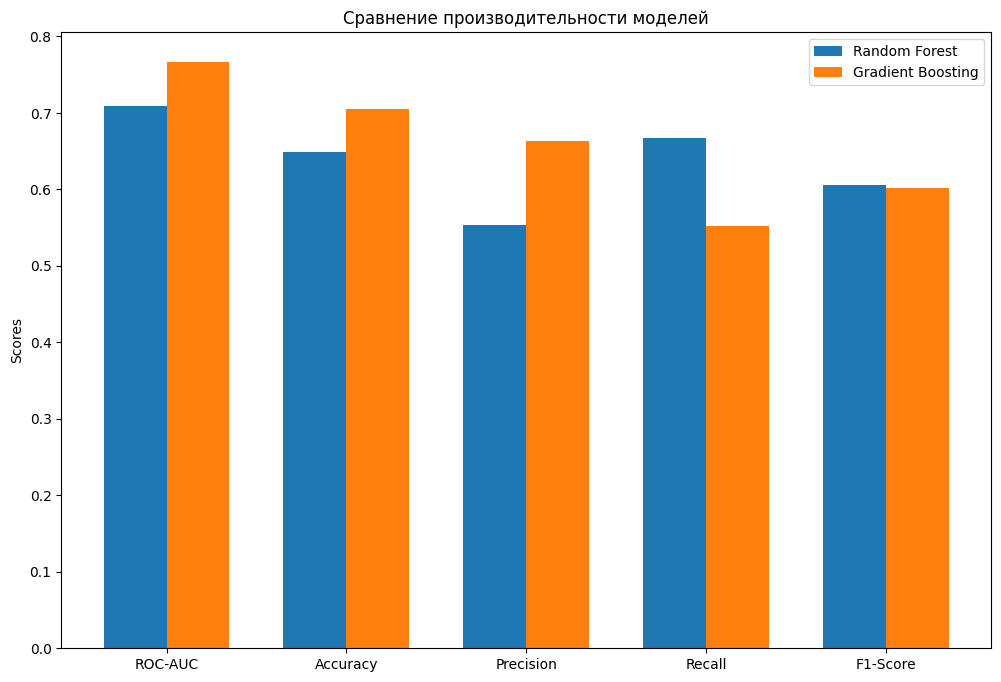

In [54]:
metrics = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_scores = [rf_roc_auc, rf_accuracy, rf_precision, rf_recall, rf_f1]
gb_scores = [gb_roc_auc, gb_accuracy, gb_precision, gb_recall, gb_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest')
rects2 = ax.bar(x + width/2, gb_scores, width, label='Gradient Boosting')

ax.set_ylabel('Scores')
ax.set_title('Сравнение производительности моделей')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

In [55]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [56]:
print("\n" + "="*50)
if rf_roc_auc > gb_roc_auc:
    final_model = pipeline_rf
    best_model_name = "Random Forest"
    best_params = best_params_rf
    best_score = rf_roc_auc
    print(f"Лучшая модель: Random Forest (ROC-AUC: {rf_roc_auc:.4f})")
else:
    final_model = pipeline_gb
    best_model_name = "Gradient Boosting"
    best_params = best_params_gb
    best_score = gb_roc_auc
    print(f"Лучшая модель: Gradient Boosting (ROC-AUC: {gb_roc_auc:.4f})")

print("Лучшие параметры:", best_params)


Лучшая модель: Gradient Boosting (ROC-AUC: 0.7671)
Лучшие параметры: {'n_estimators': 465, 'learning_rate': 0.10000661955341474, 'max_depth': 8, 'subsample': 0.8695194175199982}


In [57]:
print("\nПодробный отчет для лучшей модели:")
if best_model_name == "Random Forest":
    y_pred = rf_pred
    y_pred_proba = rf_pred_proba
else:
    y_pred = gb_pred
    y_pred_proba = gb_pred_proba

print(classification_report(y_test, y_pred))


Подробный отчет для лучшей модели:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77     39544
           1       0.66      0.55      0.60     26791

    accuracy                           0.71     66335
   macro avg       0.70      0.68      0.68     66335
weighted avg       0.70      0.71      0.70     66335



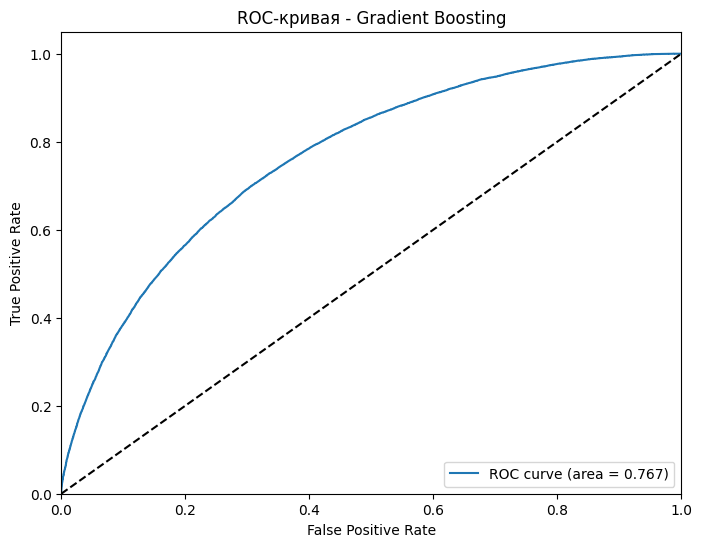

In [59]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {best_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

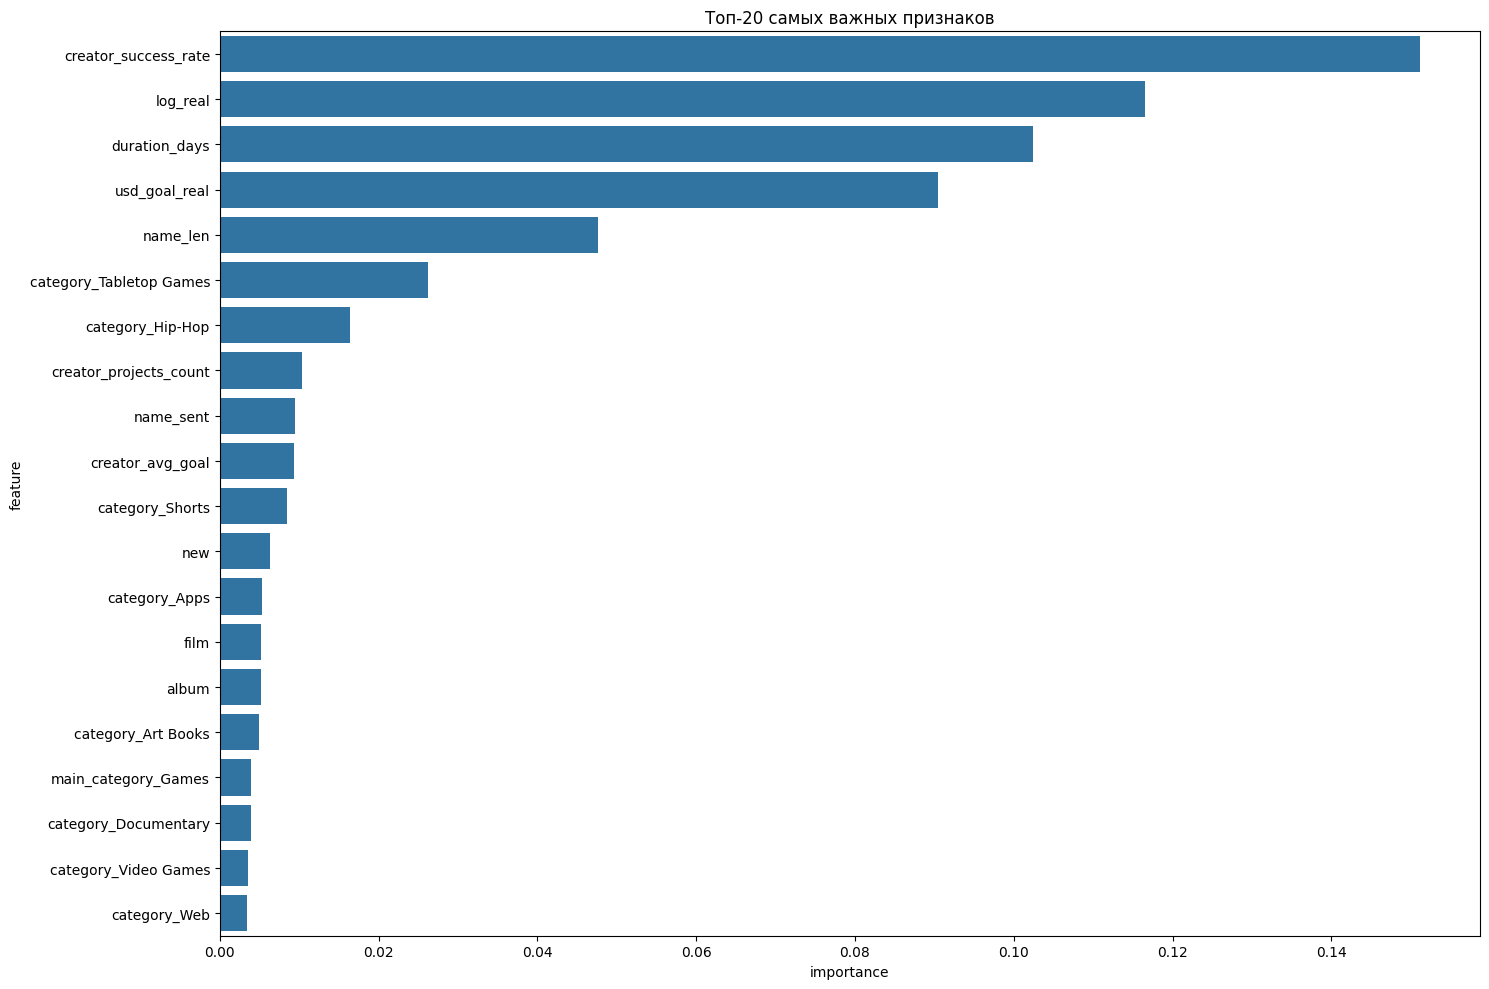

,feature,importance
6,creator_success_rate,0.151167
2,log_real,0.116496
1,duration_days,0.102409
0,usd_goal_real,0.090474
3,name_len,0.047683
144,category_Tabletop Games,0.026228
76,category_Hip-Hop,0.016455
5,creator_projects_count,0.010381
4,name_sent,0.009468
7,creator_avg_goal,0.009302


In [60]:
feature_names = []
feature_names.extend(numeric_features)

categorical_transformer_fit = final_model.named_steps['preprocessor'].transformers_[1][1]
categorical_encoder = categorical_transformer_fit.named_steps['onehot']
categorical_features_fit = final_model.named_steps['preprocessor'].transformers_[1][2]
categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features_fit)
feature_names.extend(categorical_feature_names)

text_transformer_fit = final_model.named_steps['preprocessor'].transformers_[2][1]
text_vectorizer = text_transformer_fit.named_steps['tfidf']
text_feature_names = text_vectorizer.get_feature_names_out()
feature_names.extend(text_feature_names)

importances = final_model.named_steps['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Топ-20 самых важных признаков')
plt.tight_layout()
plt.show()

feature_importance_df.head(10)

In [61]:
import joblib
joblib.dump(final_model, 'best_model.pkl')
print(f"\nЛучшая модель сохранена как 'best_model.pkl'")


Лучшая модель сохранена как 'best_model.pkl'
